In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/HPDC22/3D-GAN")

data_path = "/content/drive/MyDrive/Colab Notebooks/HPDC22/CAE-FE"

In [ ]:
import struct
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torchsummary import summary

"""
Implementation based on original paper NeurIPS 2016 https://papers.nips.cc/paper/6096-learning-a-probabilistic-latent-space-of-object-shapes-via-3d-generative-adversarial-modeling.pdf
"""

'\nImplementation based on original paper NeurIPS 2016 https://papers.nips.cc/paper/6096-learning-a-probabilistic-latent-space-of-object-shapes-via-3d-generative-adversarial-modeling.pdf\n'

In [ ]:
class ConvAE3D(torch.nn.Module):
    # def __init__(self, in_channels=1, dim=64, n_hidden=128):
    def __init__(self, n_hidden=128):
        super(ConvAE3D, self).__init__()
        
        conv1_channels = 16
        conv2_channels = 32
        conv3_channels = 64
        # out_channels = 1
        self.n_hidden = n_hidden  # 128
        self.out_dim = 4

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv3d(
                in_channels=1, out_channels=conv1_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv1_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv2_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv3_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv3_channels, out_channels=n_hidden, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(n_hidden),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Decoder
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=n_hidden, out_channels=conv3_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv3_channels),
            nn.ReLU(inplace=True)
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv3_channels, out_channels=conv2_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv2_channels),
            nn.ReLU(inplace=True)
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv2_channels, out_channels=conv1_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv1_channels),
            nn.ReLU(inplace=True)
        )
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv1_channels, out_channels=1, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
        )
        # if activation == "sigmoid":
        self.out = torch.nn.Sigmoid()
        # else:
        #     self.out = torch.nn.Tanh()

    def encoder(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

    def decoder(self, x):
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        return x

    def feature_extract(self, x):
        x = self.encoder(x)
        # Flatten
        x = x.view(-1, self.n_hidden * self.out_dim * self.out_dim * self.out_dim)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
from multiprocessing import Pool

ndim = 64

def readfile(filename):
    with open(os.path.join(data_path, filename), "rb") as file:
        rawdata = file.read()
        floatdata = struct.unpack("f"*(ndim*ndim*ndim), rawdata)
        # print(len(floatdata))
        floatdata = np.array(floatdata, dtype=np.float32).reshape((1, ndim, ndim, ndim))
    return floatdata

file_list = ["openpmd_{:05}_Bx.dat".format(i) for i in range(0, 51200, 100)]
pool = Pool(8)
float_list = pool.map(readfile, file_list)
float_data = np.array(float_list) # num * ndim * ndim * ndim

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(float_data, batch_size=32, num_workers=2)

In [ ]:
# Initialize the model
model = ConvAE3D(n_hidden=128)

# Loss function
# criterion = nn.MSELoss()
criterion = nn.L1Loss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

# Epochs
n_epochs = 500

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    # Training
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        # print(loss)
    
    train_loss = train_loss/len(train_loader)
    if epoch % 20 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

cuda:0
Epoch: 20 	Training Loss: 34.023092
Epoch: 40 	Training Loss: 21.999916
Epoch: 60 	Training Loss: 13.708389
Epoch: 80 	Training Loss: 10.107643
Epoch: 100 	Training Loss: 8.509887
Epoch: 120 	Training Loss: 7.854353
Epoch: 140 	Training Loss: 7.795176
Epoch: 160 	Training Loss: 7.028440
Epoch: 180 	Training Loss: 6.724148
Epoch: 200 	Training Loss: 6.220187
Epoch: 220 	Training Loss: 6.018505
Epoch: 240 	Training Loss: 5.724909
Epoch: 260 	Training Loss: 5.798784
Epoch: 280 	Training Loss: 6.124173
Epoch: 300 	Training Loss: 5.607773
Epoch: 320 	Training Loss: 5.474646
Epoch: 340 	Training Loss: 5.207173
Epoch: 360 	Training Loss: 5.259042
Epoch: 380 	Training Loss: 5.194609
Epoch: 400 	Training Loss: 5.627720
Epoch: 420 	Training Loss: 5.265062
Epoch: 440 	Training Loss: 5.135213
Epoch: 460 	Training Loss: 4.752645
Epoch: 480 	Training Loss: 4.898277
Epoch: 500 	Training Loss: 4.587164


In [ ]:
data = data.cpu().detach().numpy()
out = out.cpu().detach().numpy()

(array([4.200000e+01, 1.210000e+02, 2.870000e+02, 2.714000e+03,
        5.722100e+04, 8.304536e+06, 1.816800e+04, 4.615000e+03,
        8.140000e+02, 9.000000e+01]),
 array([-2.8138902 , -2.2859788 , -1.7580673 , -1.2301558 , -0.70224434,
        -0.17433286,  0.35357863,  0.8814901 ,  1.4094015 ,  1.9373131 ,
         2.4652245 ], dtype=float32),
 <a list of 10 Patch objects>)

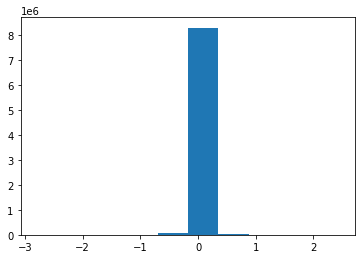

In [ ]:
import matplotlib.pyplot as plt
plt.hist(data.flatten() - out.flatten())

In [ ]:
np.mean(data)

0.0010860487

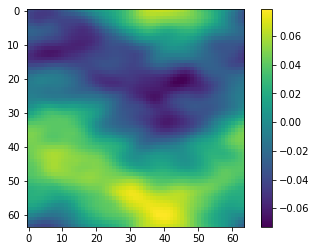

In [ ]:
plt.imshow(data[0][0][:][:][32])
plt.colorbar()

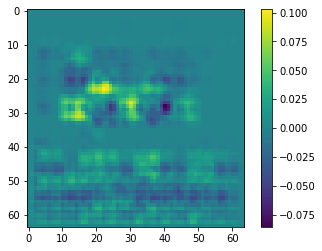

In [ ]:
plt.imshow(out[0][0][:][:][32])
plt.colorbar()

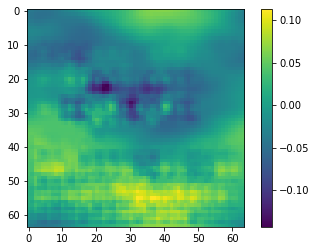

In [ ]:
plt.imshow(data[0][0][32][:][:] - out[0][0][32][:][:])
plt.colorbar()

In [ ]:
data.shape

(32, 1, 64, 64, 64)

## MLP

In [ ]:
# encoded features
feature = model.encoder(torch.tensor(data).to(device))
# Flatten
feature = feature.view(-1, 128 * 4 * 4 * 4)

In [ ]:
len(feature[0])

8192

In [ ]:
appname = "Beam64"
varname = "Bx"
dname = "mgard_WarpX_{}_{}_0_256.csv".format(appname, varname)
data_path = "/content/drive/MyDrive/Colab Notebooks/HPDC22/expr_20211224"
# X_train, X_test, Y_train, Y_test = preprocess(dname)

In [ ]:
df_features = pd.read_csv(os.path.join(data_path, dname))

In [ ]:
df_features

,timestep,relerr,datarange,RequestedTolerance,EstimatedError,bp_0,bp_1,bp_2,bp_3,bp_4,maxvalue,minvalue,avgvalue,maxerror
0,100,9*10^-1,4.65*10^02,4.185000e+02,3.827180e+02,8,9,6,5,3,232.423035,-232.178787,-0.000045,2.726947e+01
1,100,8*10^-1,4.65*10^02,3.720000e+02,3.383450e+02,8,9,7,5,3,232.423035,-232.178787,-0.000045,2.442567e+01
2,100,7*10^-1,4.65*10^02,3.255000e+02,2.495980e+02,8,9,7,5,4,232.423035,-232.178787,-0.000045,1.491383e+01
3,100,6*10^-1,4.65*10^02,2.790000e+02,2.495980e+02,8,9,7,5,4,232.423035,-232.178787,-0.000045,1.491383e+01
4,100,5*10^-1,4.65*10^02,2.325000e+02,1.899720e+02,10,10,7,6,4,232.423035,-232.178787,-0.000045,1.197116e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20731,25600,5*10^-9,9.34*10^00,4.670000e-08,9.810000e-08,32,32,32,32,32,4.692245,-4.651989,-0.001588,9.540000e-07
20732,25600,4*10^-9,9.34*10^00,3.740000e-08,9.810000e-08,32,32,32,32,32,4.692245,-4.651989,-0.001588,9.540000e-07
20733,25600,3*10^-9,9.34*10^00,2.800000e-08,9.810000e-08,32,32,32,32,32,4.692245,-4.651989,-0.001588,9.540000e-07
20734,25600,2*10^-9,9.34*10^00,1.870000e-08,9.810000e-08,32,32,32,32,32,4.692245,-4.651989,-0.001588,9.540000e-07


In [ ]:
err_feature = df_features[df_features.timestep == 100].RequestedTolerance.values

In [ ]:
target_b0 = np.array(df_features[df_features.timestep == 100].bp_0.values).reshape(81, 1)
target_b1 = np.array(df_features[df_features.timestep == 100].bp_1.values).reshape(81, 1)
target_b2 = np.array(df_features[df_features.timestep == 100].bp_2.values).reshape(81, 1)
target_b3 = np.array(df_features[df_features.timestep == 100].bp_3.values).reshape(81, 1)
target_b4 = np.array(df_features[df_features.timestep == 100].bp_4.values).reshape(81, 1)

In [ ]:
np.shape(target_b0)

(81, 1)

In [ ]:
latent_feature = feature[0].detach().cpu()

In [ ]:
training_data = []
training_target = np.concatenate((target_b0, target_b1, target_b2, target_b3, target_b4), axis=1)
for i in range(0, len(err_feature)):
    err = err_feature[i]
    training_feature = np.append(latent_feature.numpy().flatten(), err)
    training_target_ = training_target[i]
    training_data.append([training_feature, training_target[i]])

In [ ]:
# (training_data).shape

In [ ]:
def preprocess(dname):
    df_features = pd.read_csv(dname)
    
    for i in range(0, len(df_features.datarange)):
        df_features.datarange.values[i] = np.float(df_features.datarange.values[i].replace("*10^", "e"))

    # normalization: (z = x - mean(x))/(max(x) - min(x))
    norm_mean = np.mean(df_features["maxerror"])
    norm_max =  np.max(df_features["maxerror"])
    norm_min =  np.min(df_features["maxerror"])

    for col in ["maxerror"]:
        df_features[col] = (df_features[col] - norm_mean)/(norm_max - norm_min)

    # split training and testing set
    df_data_feature = df_features[["minvalue", "maxvalue", "avgvalue", "maxerror"]].copy()
    df_data_target  = df_features[["bp_0", "bp_1", "bp_2", "bp_3", "bp_4"]].copy()

    df_data_feature  = np.array(df_data_feature.astype("float32"))
    df_data_target   = np.array(df_data_target.astype("float32")).reshape(len(df_features["timestep"]), 5)

    df_training_feature = df_data_feature[0:10368]
    df_training_target = df_data_target[0:10368]
    # df_training_feature = df_data_feature
    # df_training_target = df_data_target

    X_train, X_test, Y_train, Y_test = train_test_split(df_training_feature, df_training_target, test_size=0.3, 
                                                        shuffle=True, random_state=2)
    return X_train, X_test, Y_train, Y_test

In [ ]:
def train(X_train, Y_train):
    x_train = Variable(torch.from_numpy(X_train))
    y_train = Variable(torch.from_numpy(Y_train))

    net = torch.nn.Sequential( # 128 latent feature + err + data range
            torch.nn.Linear(8192, 4080),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 5),
            )

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    # loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
    loss_func = torch.nn.L1Loss()

    BATCH_SIZE = 64
    EPOCH = 1000

    torch_dataset = Data.TensorDataset(x_train, y_train)

    loader = Data.DataLoader(
        dataset=torch_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, num_workers=2,)

    # start training
    for epoch in range(EPOCH):
        for step, (batch_x, batch_y) in enumerate(loader): # for each training step
            
            b_x = Variable(batch_x)
            b_y = Variable(batch_y)
            prediction = net(b_x)     # input x and predict based on x
            loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)
            # print(loss)
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
        if epoch % 10 == 0:
            print(loss.detach().numpy())
    return net